# Compairing the Neighborhoods of Chicago & Houston
### Applied Data Science Capstone by: Nick Adelberger

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

Chicago, on Lake Michigan in Illinois, is the 3rd largest city in the United States and is home to more than 2.7 million people. Known as "The Windy City", Chicago is an international hub for finance, culture, commerce, industry, education, technology, telecommunications, and transportation (reference: https://en.wikipedia.org/wiki/Chicago). Houston, popularly known as "The Bayou City", is set to become the 4th largest city in the United States by the second half of 2020. Houston's economy has a broad industrial base in energy, manufacturing, aeronautics, and transportation. It has become a global city, with strengths in culture, medicine and research (reference: https://en.wikipedia.org/wiki/Houston).

As a current resident of Chicago, I have been offered a job in Houston as a Data Anaylist. Before accepting the position, I would like to discover more insight into the city of Houston to find any similarities or dissimilarities to Chicago.

Since there are a lot of neighborhoods within both cities, I will first try to detect the **distinct venues** that make up the **North Side of Chicago** since I currently live within that area. I will then break down the City of Houston into similar areas to compare and contrast so that I can **find the area of Houston that is similar to where I live in Chicago.**

I will use my data science powers to generate a few most promissing neighborhoods based on the above criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by anyone who is considering moving to Houston.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* Neighborhoods and Areas within Houston
* Neighborhoods in Chicago that are located on the North Side
* The top 10 venues that make up the neighborhood areas for comparision

Following data sources will be needed to extract/generate the required information:
* List of neighborhoods in both Chicago & Houston using **Google Search**
    * Chicago Neighborhoods - https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago
    * Houston Neighborhoods - https://www.houston.org/living-in-houston/neighborhoods-communities
* Coordinates (latitude & longitude) of each neighborhood using **Python Geopy Geocorders**
* Types of venues located within each neighborhood using **Foursquare API**

### Chicago Neighborhood Candidates

Let's create a data frame of the Neighborhoods located on the North Side of Chicago. We will use pythons **BeautifulSoup** package to scrape the Wikipedia webpage to obtain the Neighborhoods.

In [1]:
# Import Libraries
import requests
import urllib.request
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

# package used for web scraping
from bs4 import BeautifulSoup

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

print('Libraries imported.')

Libraries imported.


In [2]:
# speify the URL of wikipedia page to scrape
url = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago'

# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)

# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "html")

In [3]:
# use the 'find' function to bring back the 'table' tag with class 'wikitable sortable' in the HTML and store in 'chicago_table' variable
chicago_table = soup.find('table', class_='wikitable sortable')

# Make empty lists to store data from table loop
chicago_neighborhood = []
chicago_borough = []
for row in chicago_table.find_all('tr'):
    cells = row.find_all('td')
    if len(cells)==2:
        chicago_neighborhood.append(cells[0].find(text=True))
        chicago_borough.append(cells[1].find(text=True))
        
# remove the \n from chicago_neighborhood list and assign to final_chicago_neighborhood list
final_chicago_neighborhood = []
for hood in chicago_neighborhood:
    final_chicago_neighborhood.append(hood.strip())
    
# remove the \n from chicago_borough list and assign to final_chicago_borough list
final_chicago_borough = []
for bor in chicago_borough:
    final_chicago_borough.append(bor.strip())

In [4]:
# Create Dataframe
chi_df = pd.DataFrame(final_chicago_neighborhood, columns=['Neighborhood'])
chi_df['Borough'] = final_chicago_borough

# Group by Borough, seperating the Negihborhoods by a comma on same row 
chicago_df = chi_df.groupby(['Borough'])['Neighborhood'].apply(', '.join).reset_index()
chicago_df.head()

,Borough,Neighborhood
0,Albany Park,"Albany Park, Mayfair, North Mayfair, Ravenswoo..."
1,Archer Heights,Archer Heights
2,Armour Square,"Armour Square, Chinatown, Wentworth Gardens"
3,Ashburn,"Ashburn, Ashburn Estates, Beverly View, Crestl..."
4,Auburn Gresham,"Auburn Gresham, Gresham"


Now that we have created a data frame consisting of the Boroughs & Neighborhoods, let's use Pythons **Geocoder** package to get the coordinates using the values from the Borough Column and add that to the data frame.

From there we will then use the coordinates to find the area of Chicago the Boroughs are located in, group by the area and obtain a final data frame of the Boroughs and Neighborhoods located on the North Side of Chicago.

In [5]:
# Import the module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# Turn the column Borough from chicago_df to list for computing latitude/longitude coordinates
borough_list = chicago_df['Borough'].to_list()

# Create empty lists for lat and lng coordinates
chi_lat = []
chi_lng = []

# Create for loop to find Latitude and Longitude for each borough and append to lists
for bor in borough_list:
    address = (bor + ', Chicago')
    geolocator = Nominatim(user_agent='chi_explorer')
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    chi_lat.append(latitude)
    chi_lng.append(longitude)

In [6]:
# add chi_lat and chi_lng coordinates to chicago_df and view data frame
chicago_df['Latitude'] = chi_lat
chicago_df['Longitude'] = chi_lng

chicago_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Albany Park,"Albany Park, Mayfair, North Mayfair, Ravenswoo...",41.971937,-87.716174
1,Archer Heights,Archer Heights,41.811422,-87.726165
2,Armour Square,"Armour Square, Chinatown, Wentworth Gardens",41.840033,-87.633107
3,Ashburn,"Ashburn, Ashburn Estates, Beverly View, Crestl...",41.747533,-87.711163
4,Auburn Gresham,"Auburn Gresham, Gresham",41.743387,-87.656042


Group Neighborhoods by area of city they are located:
* North = 0
* West = 1
* South = 2
* Downtown = 3

In [7]:
# Add Column Area to data frame with values containing city area as outlined above
chicago_df['Area'] = [0,2,2,2,2,1,2,1,1,2,2,2,2,2,2,2,2,2,1,1,2,0,0,2,0,2,2,2,2,2,2,1,1,2,0,0,2,0,0,0,0,1,1,2,1,2,2,3,3,3,2,0,1,0,1,1,2,1,2,2,0,2,2,2,1,2,3,0,2,2,2,2,1,2,2,0,1,2]

# Create new column for Zone Names
chicago_df['Zone'] = chicago_df['Area']

# Set Zone names based on values specified above
chicago_df.loc[chicago_df['Area'] == 0, 'Zone'] = 'North'
chicago_df.loc[chicago_df['Area'] == 1, 'Zone'] = 'West'
chicago_df.loc[chicago_df['Area'] == 2, 'Zone'] = 'South'
chicago_df.loc[chicago_df['Area'] == 3, 'Zone'] = 'Downtown'
chicago_df.head()

,Borough,Neighborhood,Latitude,Longitude,Area,Zone
0,Albany Park,"Albany Park, Mayfair, North Mayfair, Ravenswoo...",41.971937,-87.716174,0,North
1,Archer Heights,Archer Heights,41.811422,-87.726165,2,South
2,Armour Square,"Armour Square, Chinatown, Wentworth Gardens",41.840033,-87.633107,2,South
3,Ashburn,"Ashburn, Ashburn Estates, Beverly View, Crestl...",41.747533,-87.711163,2,South
4,Auburn Gresham,"Auburn Gresham, Gresham",41.743387,-87.656042,2,South


In [8]:
# Slice the original dataframe and create a new dataframe containing the Neighborhoods on the North Side of Chicago
north_df = chicago_df[chicago_df['Zone'] == 'North'].reset_index(drop=True)
north_chicago_df = north_df.drop(['Area', 'Zone'], axis = 1)
north_chicago_df

,Borough,Neighborhood,Latitude,Longitude
0,Albany Park,"Albany Park, Mayfair, North Mayfair, Ravenswoo...",41.971937,-87.716174
1,Edgewater,"Andersonville, Edgewater, Edgewater Beach, Edg...",41.983369,-87.663952
2,Edison Park,Edison Park,42.005733,-87.814016
3,Forest Glen,"Edgebrook, Forest Glen, Old Edgebrook, Saugana...",41.991752,-87.751674
4,Irving Park,"Avondale Gardens, Irving Park, Kilbourn Park, ...",41.953365,-87.736447
5,Jefferson Park,"Gladstone Park, Jefferson Park",41.969738,-87.763118
6,Lake View,"Boystown, Graceland West, Lake View, Lake View...",41.947050,-87.655429
7,Lakeview,Sheridan Station Corridor,41.943919,-87.654076
8,Lincoln Park,"Lincoln Park, Old Town Triangle, Park West, Ra...",41.940298,-87.638117
9,Lincoln Square,"Bowmanville, Budlong Woods, Lincoln Square, Ra...",41.975990,-87.689616


Let's visualize the data we have using **Folium** to check that the neighborhoods are located on the **North Side of Chicago**

In [9]:
import folium

# create map of Chicago using latitude and longitude values
map_chicago = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# add markers to map
for lat, lng, label in zip(north_chicago_df['Latitude'], north_chicago_df['Longitude'], north_chicago_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

...now that we have the neighborhoods located on the North Side of Chicago let's save the data into a local file.

In [10]:
north_chicago_df.to_csv('north_chicago_data.csv')

### Houston Neighborhood Candidates

Just like we did with Chicago, we will create a data frame consisting of the Houston neighborhoods.

In [11]:
# speify the URL of the webpage to scrape
url = 'https://www.houston.org/living-in-houston/neighborhoods-communities'

# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)

# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "html")

In [12]:
# use the 'find' function to bring back the 'div' tag with class 'text-timeline-year' in the HTML and store in 'houston_table' variable
houston_table = soup.find_all('div', class_='text-timeline-year')

# Make empty lists to store data from table loop
houston_neighborhood = []

for div in houston_table:
    houston_neighborhood.append(div.text)
    
# remove the \n from houston_neighborhood list and assign to final_houston_neighborhood list
final_houston_neighborhood = []
for hood in houston_neighborhood:
    final_houston_neighborhood.append(hood.strip())
    
# create dataframe
df = pd.DataFrame(final_houston_neighborhood, columns=['Neighborhood'])
df_mod = df.drop([df.index[19]]).reset_index()
houston_df = df_mod[['Neighborhood']]
houston_df.head()

,Neighborhood
0,Ballpark District
1,Civic Center District
2,Convention District
3,Historic District
4,Medical District


Again, we will use Pythons **Geocoder** package to get the coordinates using the values from the Neighborhood Column and add that to the data frame.

From there we will then use the coordinates to group the Neighborhoods based on the area of Houston they are located in and add that to the final dataframe.

In [13]:
# Create User_agent for Geopy Locator
geolocator = Nominatim(user_agent='hou_explorer')

In [14]:
# Create lambda function to get lat and lng coordinates for Neighborhoods and add columns to dataframe
houston_df['Latitude'] = houston_df['Neighborhood'].apply(lambda x: geolocator.geocode(x + ', Texas').latitude if geolocator.geocode(x + ', Texas') != None else 0)
houston_df['Longitude'] = houston_df['Neighborhood'].apply(lambda x: geolocator.geocode(x + ', Texas').longitude if geolocator.geocode(x + ', Texas') != None else 0)

In [15]:
houston_df.head()

,Neighborhood,Latitude,Longitude
0,Ballpark District,0.000000,0.000000
1,Civic Center District,33.074707,-97.069367
2,Convention District,29.754999,-95.356291
3,Historic District,33.232002,-96.902597
4,Medical District,30.275410,-97.733898


It looks like the coordinates of the Neighborhoods retreived by Geopy are a little off or missing. We will update the values in both the Latitude and Longitude with the correct coordinates.

In [16]:
new_df = pd.DataFrame({'Latitude': [29.7050,29.5420,29.8707,29.7167,29.7329,29.6459,29.6726,29.7771,29.6851,29.8016,29.8327,29.7363,29.6733,29.7598,29.7542,30.1580,29.5763,29.6681,29.7552,29.5984,29.5377,30.0799,29.7052,29.7058,29.5822,29.7408,29.7597,29.7549,29.7095,29.761993,29.7671,29.7392,29.7210,29.7475,29.9014,29.9992,30.3119,29.9119,29.9717,30.019038,29.8402,29.9988,29.8877,30.0500,29.9724,30.0972,29.4238,29.5636,29.5572,29.7355,29.5857,29.5294,29.7336,29.2410,29.3686,29.6658,29.5075,29.5447,29.7336,29.6827,29.6931,29.7278]}, index=[60,52,25,24,23,22,21,17,16,15,14,11,10,6,0,39,41,3,5,45,57,37,48,9,43,18,1,2,4,7,8,13,19,20,26,27,28,29,30,31,32,33,34,35,36,38,40,42,44,46,47,49,50,51,53,54,55,56,58,59,61,63])
houston_df.update(new_df)

new_df1 = pd.DataFrame({'Longitude': [-95.5453,-95.0170,-95.4365,-95.4169,-95.4334,-95.2769,-95.4201,-95.4355,-95.3993,-95.4381,-95.4448,-95.3043,-95.4399,-95.3633,-95.3533,-95.4894,-95.5370,-95.2802,-95.3627,-95.6226,-95.1183,-95.4172,-95.1238,-95.8245,-95.4588,-95.7608,-95.3756,-95.3680,-95.3562,-95.3982,-95.366302,-95.3551,-95.4645,-95.3858,-95.4331,-95.4001,-95.5434,-95.4561,-95.0622,-95.6938,-95.755936,-95.4149,-95.2622,-95.5630,-95.1845,-95.1380,-95.6161,-95.2441,-95.2860,-95.8086,-94.9774,-95.1328,-95.2010,-95.2302,-94.9091,-94.9713,-95.0194,-95.0949,-95.0910,-95.2302,-95.5932,-95.8999,-95.5717]}, index=[60,52,25,24,23,22,21,17,16,15,14,11,10,6,0,39,41,3,5,45,57,37,48,62,9,43,18,1,2,4,7,8,13,19,20,26,27,28,29,30,31,32,33,34,35,36,38,40,42,44,46,47,49,50,51,53,54,55,56,58,59,61,63])
houston_df.update(new_df1)

Group Neighborhoods by area of city they are located:
* Downtown = 0
* Inner Loop = 1
* North = 2
* South = 3
* East = 4
* West = 5

In [17]:
# Add Column Area to dataframe with values containing city area as outlined above
houston_df['Area'] = [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5]

# Create new column for Zone Names
houston_df['Zone'] = houston_df['Area']

# Set Zone names based on values specified above
houston_df.loc[houston_df['Area'] == 0, 'Zone'] = 'Downtown'
houston_df.loc[houston_df['Area'] == 1, 'Zone'] = 'Inner Loop'
houston_df.loc[houston_df['Area'] == 2, 'Zone'] = 'North'
houston_df.loc[houston_df['Area'] == 3, 'Zone'] = 'South'
houston_df.loc[houston_df['Area'] == 4, 'Zone'] = 'East'
houston_df.loc[houston_df['Area'] == 5, 'Zone'] = 'West'
houston_df['Neighborhood'] = houston_df['Neighborhood'].str.split('/').str[0]
houston_df.head()

,Neighborhood,Latitude,Longitude,Area,Zone
0,Ballpark District,29.7542,-95.3533,0,Downtown
1,Civic Center District,29.7597,-95.3680,0,Downtown
2,Convention District,29.7549,-95.3562,0,Downtown
3,Historic District,29.6681,-95.2802,0,Downtown
4,Medical District,29.7095,-95.3982,0,Downtown


Let's visualize the data we have using **Folium** to check that the neighborhoods are located in the correct **Areas of Houston.** We will also import MatPlotLib to use different colors based on the zone they are located in.

In [18]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_houston = folium.Map(location=[29.7604, -95.3698], zoom_start=10)

# set color scheme for the zone clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, neighborhood, area, zone in zip(houston_df['Latitude'], houston_df['Longitude'], houston_df['Neighborhood'], houston_df['Area'], houston_df['Zone']):
    label = folium.Popup(str(neighborhood) + ' | Cluster: ' + str(zone), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[area-1],
        fill=True,
        fill_color=rainbow[area-1],
        fill_opacity=0.6).add_to(map_houston)
       
map_houston

...now that we have the neighborhoods located correctly around Houston let's save the data into a local file.

In [19]:
houston_df.to_csv('houston_neighborhoods.csv')

Lets combine the two dataframes containing the Neighborhoods and Coordinates from Houston and Chicago. This will be useful for further analysis using Foursquare.

In [20]:
# Create new dataframe for Houston dropping Area and Zone Columns
houston_df_drop = houston_df.drop(['Area', 'Zone'], axis = 1)

# Creat new dataframe for Chicago dropping Neighborhood Column and renaming the Borough Column to Neighborhood
north_chicago_df_drop = north_chicago_df.drop(['Neighborhood'], axis = 1)
north_chicago_df_drop = north_chicago_df_drop.rename(columns={'Borough':'Neighborhood'})

# Combine both dataframes using outer join and set to new dataframe
chicago_houston_df = pd.merge(houston_df_drop, north_chicago_df_drop, how='outer')

# Create column City with values Chicago or Houston based on condition of Latitude
chicago_houston_df['City'] = ['Houston' if x < 40 else 'Chicago' for x in chicago_houston_df['Latitude']]
chicago_houston_df.head()

,Neighborhood,Latitude,Longitude,City
0,Ballpark District,29.7542,-95.3533,Houston
1,Civic Center District,29.7597,-95.3680,Houston
2,Convention District,29.7549,-95.3562,Houston
3,Historic District,29.6681,-95.2802,Houston
4,Medical District,29.7095,-95.3982,Houston


In [21]:
#chicago_houston_df.to_csv('chicago_houston_df.csv')

### Foursquare
Now that we have our location candidates, let's use Foursquare API to create a dataframe consisting of the venues around each neighborhood.

Foursquare credentials are defined in hidden cell bellow.

In [22]:
CLIENT_ID = 'LJW3JEYQVFZXNPN3KPP2CGNS3S1EP3XFXUNV4XHQHWQSYUDO'
CLIENT_SECRET = '51M4OTN441QV0IZ1WZVAXFCFDDTNLFBVD53BUZQLMXQZ3HJ4'
VERSION = '20180605'

Let's create a function to get a list of nearby venues within each neighborhood. We will set the radius to 500 meters and limit the results to 100.

In [23]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
chicago_houston_venues = getNearbyVenues(names=chicago_houston_df['Neighborhood'],
                                 latitudes=chicago_houston_df['Latitude'],
                                 longitudes=chicago_houston_df['Longitude']
                                )

Ballpark District
Civic Center District
Convention District
Historic District
Medical District
Shopping District
Skyline District
Theater District
Warehouse District
Bellaire
Braeburn
EaDo
Fifth Ward
Uptown
Garden Oaks
Heights
Medical Center
Memorial Park
Midtown
Museum District
River Oaks
South Main
Third Ward
Upper Kirby
West University
Northside
Aldine
Champions
Conroe
Crosby
Cypress
Cypress Fairbanks
North Houston District
Humble
Jersey Village
Kingwood
Lake Houston
Spring
Tomball
The Woodlands
Alvin
Missouri City
Pearland
Richmond
Rosenberg
Sugar Land
Baytown
Clear Lake
Deer Park
Friendswood
Galena Park
Galena Park
Galveston Island
Kemah
La Marque
La Porte
League City
Nassau Bay
Webster
Alief
Chinatown
Fulshear
Katy
Westchase
Albany Park
Edgewater
Edison Park
Forest Glen
Irving Park
Jefferson Park
Lake View
Lakeview
Lincoln Park
Lincoln Square
North Center
North Park
Rogers Park
Uptown
West Ridge


Let's check the shape of the dataframe and save into a local file

In [25]:
print(chicago_houston_venues.shape)
#chicago_houston_venues.to_csv('chicago_houston_venues.csv')

(1776, 7)


Now that we have the venues located nearby each neighborhood in Houston and the North Side of Chicago, this will conclude our data gathering phase. We are now ready to use the data for analysis to produce a list of Neighborhoods in Houston similar to where we live in Chicago. 

## Methodology <a name="methodology"></a>

In this project we will direct our efferts in determining areas of Houston that are similar to where we live in the North Side of Chicago.

In the first step we have collected the required **data: neighborhoods, location(longitude & latitude), and venues nearby and within each neighborhood**(according to Foursquare API results).

The second and final step in our analysis will be to find the **top 10** venues within each neighborhood using **One Hot Encoding**, then we will combine the neighborhoods from Chicago and Houston into one dataframe where we will run **k-means clustering** to find the cluster of neighborhoods in Houston that are similar to those in Chicago.

## Analysis <a name="analysis"></a>

Let's use One Hot Encoding on the dataframe chicago_houston_venues to create a new dataframe of the neighborhoods and venue categories nearby. We will then group rows by neighborhood and by taking the mean of the frequency of occurance of each category.

In [26]:
# Create One Hot Encoding Function
def oneHotEncoding(venues,neighborhoods):
    
    # one hot encoding
    df_onehot = pd.get_dummies(venues, prefix="", prefix_sep="")
    
    # add neighborhood column back to dataframe
    df_onehot['Neighborhood'] = neighborhoods
    
    # move neighborhood column to the first column
    fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
    df_onehot = df_onehot[fixed_columns]
    return df_onehot

In [27]:
# Run the oneHotEncoding function on the venues dataframes
chicago_houston_onehot = oneHotEncoding(venues=chicago_houston_venues[['Venue Category']], neighborhoods=chicago_houston_venues['Neighborhood'])

# Group rows by neighborhood and by taking the mean of the frequency of occurance for each categroy
chicago_houston_grouped = chicago_houston_onehot.groupby('Neighborhood').mean().reset_index()
chicago_houston_grouped.head(10)

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport Service,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorsports Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Repair Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Road,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Soccer Field,Soccer Stadium,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Warehouse,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Albany Park,0.0,0.071429,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0,0.071429,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00

Let's confirm the new size of our dataframes

In [28]:
print(chicago_houston_grouped.shape)

(76, 265)


Now we will write a function to sort the venues in descending order and then create a new dataframe displaying the **top 10** venues for each neighborhood.

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Top 10 Venues by Neighborhood

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
chicago_houston_venues_sorted = pd.DataFrame(columns=columns)
chicago_houston_venues_sorted['Neighborhood'] = chicago_houston_grouped['Neighborhood']

for ind in np.arange(chicago_houston_grouped.shape[0]):
    chicago_houston_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_houston_grouped.iloc[ind, :], num_top_venues)

chicago_houston_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Cocktail Bar,Fried Chicken Joint,Bakery,Grocery Store,Korean Restaurant,Sandwich Place,Karaoke Bar,Chinese Restaurant,Bus Station,Donut Shop
1,Aldine,Food Truck,Convenience Store,Fast Food Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market,Filipino Restaurant
2,Alief,Construction & Landscaping,Yoga Studio,Fast Food Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Farm,Farmers Market,Filipino Restaurant
3,Alvin,American Restaurant,Mexican Restaurant,Bank,Seafood Restaurant,Italian Restaurant,BBQ Joint,Sushi Restaurant,Bowling Alley,Food & Drink Shop,Flower Shop
4,Ballpark District,Bar,Baseball Stadium,Soccer Stadium,Sports Bar,Italian Restaurant,Coffee Shop,BBQ Joint,Music Venue,Gym,Light Rail Station
5,Baytown,Fast Food Restaurant,Taco Place,Gym,Health & Beauty Service,American Restaurant,Bakery,Flower Shop,Flea Market,Filipino Restaurant,Ethiopian Restaurant
6,Bellaire,Boat or Ferry,Business Service,Pharmacy,Yoga Studio,Farm,Event Service,Event Space,Exhibit,Fabric Shop,Farmers Market
7,Braeburn,Athletics & Sports,Restaurant,Mexican Restaurant,Soccer Field,Yoga Studio,Farm,Event Service,Event Space,Exhibit,Fabric Shop
8,Champions,Gaming Cafe,Yoga Studio,Empanada Restaurant,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Filipino Restaurant,Fast Food Restaurant,Farmers Market
9,Chinatown,Chinese Restaurant,Vietnamese Restaurant,Bubble Tea Shop,Bakery,Dessert Shop,Sushi Restaurant,Asian Restaurant,Supermarket,Vegetarian / Vegan Restaurant,Noodle House


...and lets save the dataframe into a local file.

In [31]:
chicago_houston_venues_sorted.to_csv('chicago_houston_top_10.csv')

### K-Means Clustering

Now that we have the top 10 venues within each neighborhood, we will run **k-means clustering** to cluster the neighborhoods into similar clusters based on the type of venues that make up the top 10. From there we will further examine the clusters containing chicago neighborhoods to determine the most similar neighborhoods in Houston to that of Chicago.

In [32]:
# import libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

We will first attempted to determine the **optimal number** of clusters we should use for the K-Means clustering by using the **Elbow Meathod**.

In [33]:
chicago_houston_grouped_clustering = chicago_houston_grouped.drop('Neighborhood', 1)

mms = MinMaxScaler()
mms.fit(chicago_houston_grouped_clustering)
data_transformed = mms.transform(chicago_houston_grouped_clustering)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

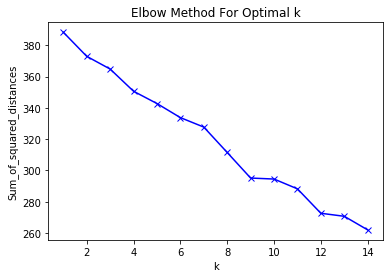

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It looks like the optimal K value would be at 9 as this is where the break in the line is located at.

In [38]:
# set number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_houston_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([7, 5, 4, 2, 7, 7, 7, 2, 3, 7], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [43]:
# add clustering labels
chicago_houston_venues_sorted.insert(0, 'Clusters', kmeans.labels_)

chicago_houston_merged = chicago_houston_df

# merge chicago_houston_grouped with chicago_houston_data to add latitude/longitude/city for each neighborhood
chicago_houston_merged = chicago_houston_merged.join(chicago_houston_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
chicago_houston_merged.head()

,Neighborhood,Latitude,Longitude,City,Clusters,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ballpark District,29.7542,-95.3533,Houston,7.0,7.0,Bar,Baseball Stadium,Soccer Stadium,Sports Bar,Italian Restaurant,Coffee Shop,BBQ Joint,Music Venue,Gym,Light Rail Station
1,Civic Center District,29.7597,-95.3680,Houston,7.0,7.0,Theater,Hotel,Burger Joint,Park,Italian Restaurant,Coffee Shop,Sandwich Place,Performing Arts Venue,Thai Restaurant,Concert Hall
2,Convention District,29.7549,-95.3562,Houston,7.0,7.0,Hotel,Bar,Italian Restaurant,Baseball Stadium,Mexican Restaurant,Sports Bar,Music Venue,Clothing Store,New American Restaurant,Light Rail Station
3,Historic District,29.6681,-95.2802,Houston,7.0,7.0,Convenience Store,Fried Chicken Joint,Hotel,Wings Joint,Dentist's Office,Mexican Restaurant,Pizza Place,Discount Store,Chinese Restaurant,Fast Food Restaurant
4,Medical District,29.7095,-95.3982,Houston,7.0,7.0,Coffee Shop,Hotel,Sandwich Place,Food Service,American Restaurant,Burger Joint,ATM,BBQ Joint,Pizza Place,Pharmacy


In [44]:
chicago_houston_merged_df = chicago_houston_merged.drop(['Clusters'], axis=1)
chicago_houston_merged_df['Cluster'] = chicago_houston_merged_df['Cluster'].fillna(0.0).astype(int)
chicago_houston_merged_df

,Neighborhood,Latitude,Longitude,City,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ballpark District,29.754200,-95.353300,Houston,7,Bar,Baseball Stadium,Soccer Stadium,Sports Bar,Italian Restaurant,Coffee Shop,BBQ Joint,Music Venue,Gym,Light Rail Station
1,Civic Center District,29.759700,-95.368000,Houston,7,Theater,Hotel,Burger Joint,Park,Italian Restaurant,Coffee Shop,Sandwich Place,Performing Arts Venue,Thai Restaurant,Concert Hall
2,Convention District,29.754900,-95.356200,Houston,7,Hotel,Bar,Italian Restaurant,Baseball Stadium,Mexican Restaurant,Sports Bar,Music Venue,Clothing Store,New American Restaurant,Light Rail Station
3,Historic District,29.668100,-95.280200,Houston,7,Convenience Store,Fried Chicken Joint,Hotel,Wings Joint,Dentist's Office,Mexican Restaurant,Pizza Place,Discount Store,Chinese Restaurant,Fast Food Restaurant
4,Medical District,29.709500,-95.398200,Houston,7,Coffee Shop,Hotel,Sandwich Place,Food Service,American Restaurant,Burger Joint,ATM,BBQ Joint,Pizza Place,Pharmacy
5,Shopping District,29.755200,-95.362700,Houston,7,Hotel,Sandwich Place,New American Restaurant,Steakhouse,Burger Joint,Mexican Restaurant,Coffee Shop,Hotel Bar,Lounge,Shopping Mall
6,Skyline District,29.759800,-95.363300,Houston,7,Burger Joint,Bar,Hotel,Cocktail Bar,Mexican Restaurant,Coffee Shop,Park,Taco Place,Southern / Soul Food Restaurant,New American Restaurant
7,Theater District,29.761993,-95.366302,Houston,7,Bar,Park,Theater,Burger Joint,Coffee Shop,New American Restaurant,Concert Hall,Mexican Restaurant,Cocktail Bar,Lounge
8,Warehouse District,29.767100,-95.355100,Houston,7,Art Gallery,Music Venue,Mexican Restaurant,Café,Smoothie Shop,Park,Sandwich Place,Coffee Shop,Performing Arts Venue,Restaurant
9,Bellaire,29.705800,-95.458800,Houston,7,Boat or Ferry,Business Service,Pharmacy,Yoga Studio,Farm,Event Service,Event Space,Exhibit,Fabric Shop,Farmers Market


...and lets save this dataframe into a local file.

In [45]:
chicago_houston_merged_df.to_csv('chicago_houston_cluster_df.csv')

Lets visualize the resulting clusters around Houston.

In [46]:
# create map
map_clusters = folium.Map(location=[29.7604, -95.3698], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_houston_merged_df['Latitude'], chicago_houston_merged_df['Longitude'], chicago_houston_merged_df['Neighborhood'], chicago_houston_merged_df['Cluster']):
    label = folium.Popup(str(poi) + ' / Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's visualize the resulting clusters around Chicago.

In [47]:
# create map
map_clusters_1 = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_houston_merged_df['Latitude'], chicago_houston_merged_df['Longitude'], chicago_houston_merged_df['Neighborhood'], chicago_houston_merged_df['Cluster']):
    label = folium.Popup(str(poi) + ' / Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_1)
       
map_clusters_1

As we can see from the two maps. Every neighborhood within the North Side of Chicago is in cluster 7.

### Cluster 7

In [48]:
cluster_7 = chicago_houston_merged_df.loc[chicago_houston_merged_df['Cluster'] == 7, chicago_houston_merged_df.columns[[0] + [3] + list(range(5, chicago_houston_merged_df.shape[1]))]]
cluster_7

,Neighborhood,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ballpark District,Houston,Bar,Baseball Stadium,Soccer Stadium,Sports Bar,Italian Restaurant,Coffee Shop,BBQ Joint,Music Venue,Gym,Light Rail Station
1,Civic Center District,Houston,Theater,Hotel,Burger Joint,Park,Italian Restaurant,Coffee Shop,Sandwich Place,Performing Arts Venue,Thai Restaurant,Concert Hall
2,Convention District,Houston,Hotel,Bar,Italian Restaurant,Baseball Stadium,Mexican Restaurant,Sports Bar,Music Venue,Clothing Store,New American Restaurant,Light Rail Station
3,Historic District,Houston,Convenience Store,Fried Chicken Joint,Hotel,Wings Joint,Dentist's Office,Mexican Restaurant,Pizza Place,Discount Store,Chinese Restaurant,Fast Food Restaurant
4,Medical District,Houston,Coffee Shop,Hotel,Sandwich Place,Food Service,American Restaurant,Burger Joint,ATM,BBQ Joint,Pizza Place,Pharmacy
5,Shopping District,Houston,Hotel,Sandwich Place,New American Restaurant,Steakhouse,Burger Joint,Mexican Restaurant,Coffee Shop,Hotel Bar,Lounge,Shopping Mall
6,Skyline District,Houston,Burger Joint,Bar,Hotel,Cocktail Bar,Mexican Restaurant,Coffee Shop,Park,Taco Place,Southern / Soul Food Restaurant,New American Restaurant
7,Theater District,Houston,Bar,Park,Theater,Burger Joint,Coffee Shop,New American Restaurant,Concert Hall,Mexican Restaurant,Cocktail Bar,Lounge
8,Warehouse District,Houston,Art Gallery,Music Venue,Mexican Restaurant,Café,Smoothie Shop,Park,Sandwich Place,Coffee Shop,Performing Arts Venue,Restaurant
9,Bellaire,Houston,Boat or Ferry,Business Service,Pharmacy,Yoga Studio,Farm,Event Service,Event Space,Exhibit,Fabric Shop,Farmers Market


In [49]:
# save cluster into local file
cluster_7.to_csv('cluster_7.csv')

In [69]:
print('==============================================================')
print('Neighborhoods of Houston recommended for further analysis')
print('==============================================================\n')

houston = cluster_7[cluster_7['City'] == 'Houston']
print(houston.to_string(columns=['Neighborhood'], index=False))


Neighborhoods of Houston recommended for further analysis

           Neighborhood
      Ballpark District
  Civic Center District
    Convention District
      Historic District
       Medical District
      Shopping District
       Skyline District
       Theater District
     Warehouse District
               Bellaire
                   EaDo
                 Uptown
                Heights
         Medical Center
          Memorial Park
                Midtown
        Museum District
             River Oaks
            Upper Kirby
        West University
              Northside
                 Conroe
                 Crosby
                Cypress
 North Houston District
                 Humble
               Kingwood
           Lake Houston
                 Spring
                Tomball
          The Woodlands
          Missouri City
               Richmond
             Sugar Land
                Baytown
             Clear Lake
              Deer Park
            Friendswood
     

This concludes our analysis. We have found 43 different Neighborhoods located throughout Houston that have similar venues to Chicago. By using the Top 10 venues we can assume at the very least that these neighborhoods will have a similar feel as for the types of venues within. That being said, every neighborhood has a different feel that can not be known by just venue type alone. Also, our list is rather large and I would consider breaking down to searching by radius of areas containing multiple neighborhoods to hopefully get better clustering results. What's interesting is that majority of the Houston clusters are located within the Inner Loop (Orange dots). While Houston is the 4th largest city behind Chicago, Houston population density may be spread out further while Chicago's density is much more centrally located. 

## Results and Discussion <a name="results"></a>

Our analysis shows that there are many neighborhoods in the Houston area (43 neighborhoods in total) that are similar to Chicago. Since we lived on the North Side of Chicago, we focused out attention to finding the venues that made up those neighborhoods. There are hundreds of venues located around each Neighborhood which would have made our Data large and messy for analysis. Therefore, by taking the Top 10 venues, we were able to analyize and compair the data across multiple neighborhoods.

Since we were looking to find any neighborhoods in Houston that were similar, we got the Top 10 venues for every neighborhood in Houston. This way, we were able to combine the results and run our cluster model to fit the neighborhoods in Houston to those in Chicago. To figure out the optimal amount of clusters, we ran an Elbow Method test and got a result of 9 clusters. 

We got our list of Neighborhoods similar to Chicago where we could further examine and determine which neighborhood/s would be the best fit. This, of course does not imply that those neighborhoods are the best fit for us. While they may have similar venues, neighborhoods are also definied by their culture and the residents living within. You will find all types of venues in every neighborhood, and even though these neighborhoods contained similar venues, I would suggest doing furthur analysis into each of them before commiting to move there. While we created a recommended list of Neighborhoods, these neighborhoods give us a great starting point where one can start looking into other attributes such as average age of the population, cost of living, crime data and other demographics. 

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify the neighborhoods in Houston that were similar to the neighborhoods on the north side of Chicago to help myself determine if I should accept a job and move to Houston. By determining the Top 10 venues within each neighborhood by using the Foursquare data, I was able to identify the the neighborhoods in Houston that were similar to Chicago by using k-means clustering. The list of neighborhoods generated can be used as starting points for final anaylsis to determine where I should move.

Final decission on neighborhood location will be made based on specific characteristics of neighborhoods and taking into consideration other additional factors like attractiveness of each location (proximity to park or water), cost of living (rent/own property), social and economic dynamics of every neighborhood etc.